# rossler

In [43]:
from models import *
from dataset.chaotic_system import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib qt5
%matplotlib inline
from utils import *
import copy
import os
import time
import random
import seaborn as sns


class Dict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


names = [
#     'rossler',
#     'rabinovich_fabrikant',
    'Lorenz',
#     'chua',
]
# names = [n + '1d' for n in names]

n_dim = 1
horizon = 10
N = 10000

N_h = 0
nz = 100
num_prepare = 0
num_train = 2000
num_test = 2000
train_start = 0
test_start = 5000
seed = 42
np.random.seed(seed)
random.seed(seed)


path = 'result/attention_plot'
if not os.path.exists(path):
    os.makedirs(path)


def select_model(model_confs):
    MSE = [0.0] * len(model_confs)
    for j, conf in enumerate(model_confs):
        _, model_type, kwargs = conf
        model = model_type(**kwargs)
        model.train(x_train, y_train, num_prepare=num_prepare)
        Predictions = model.predict(x_test, num_prepare=num_prepare)
        MSE[j] = mse(Predictions, y_test)
    best_model = model_confs[np.argmin(MSE)]
    return best_model
    
    
log = []
for system_name in names:
    print(system_name)
    for n_history in [20]:

        '''
        数据集
        '''
        x = np.loadtxt('dataset/'+system_name+'.csv', delimiter=',').T[:1]
        x += np.random.randn(*x.shape)*0.001

        x_train = np.vstack([select_samples(x, train_start + i, num_train+num_prepare) for i in range(n_history)])
        y_train = select_samples(x, train_start+ num_prepare + n_history, num_train)
        x_test  = np.vstack([select_samples(x, test_start + i, num_test+num_prepare) for i in range(n_history)])
        y_test  = select_samples(x, test_start + num_prepare + n_history, num_test) 
        y_test_multi  = np.vstack([select_samples(x, test_start + num_prepare + n_history + i, num_test) 
                            for i in range(horizon)])


        '''
        单步预测
        '''
        model_confs = []

#         model_confs.append(
#             [('ESN-ATTN-simple-transform', 
#             ESN_ATTN_simple, 
#             dict(
#                 N_h=N_h, 
#                 sigma=sigma, 
#                 reservoirConf=Dict(
#                     alpha=0.9,
#                     connectivity=1,
#                     nz=nz,
#                     nu=n_dim,
#                     target_rho=1.2,
#                     input_scale=1,
#                     activation=np.tanh
#                 ), 
#                 encoder='transform',
#                 skip_con=n_dim)) 
#             for sigma in [ 1/8, 1/4, 1/2, 1, 2, 4, 8]]
#         )
        model_confs.append(
            [('ESN', ESN, 
            dict(
                reservoirConf=Dict(
                    alpha=0.9,
                    connectivity=1,
                    nz=nz,
                    nu=n_dim,
                    target_rho=0.99,
                    input_scale=1,
                    activation=np.tanh
                ), 
                encoder='transform',
                skip_con=n_dim))
            ]
        )



        colors = list(cnames.keys())


        for j, confs in enumerate(model_confs):

            conf = select_model(confs)

            model_name, model_class, kwargs = conf
            print(model_name)

            model = model_class(**kwargs)
            model.train(x_train, y_train, num_prepare=num_prepare)
            
            print(model.W_o.shape)



Lorenz
ESN
(1, 102)


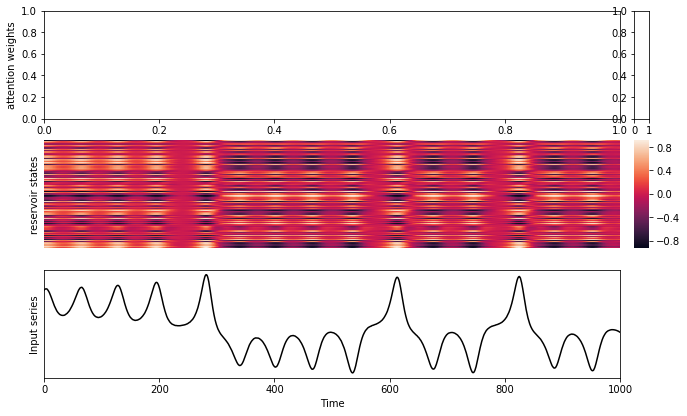

In [46]:
# %matplotlib qt5

tt = 1000
X = x_test
Z = model.encoder_func(X)
H = model._pre_output(X, Z)[:,:tt]
H1 = H[:N_h]
H2 = H[N_h:N_h+nz+1]

plt.figure(figsize=(10,6))
ax11 = plt.axes([0.1, 0.7, 0.8,0.25])
ax12 = plt.axes([0.92, 0.7, 0.02,0.25])
# sns.heatmap(H1, ax = ax11, cbar_ax=ax12, xticklabels=False, yticklabels=False)
ax11.set_ylabel('attention weights')
ax21 = plt.axes([0.1, 0.4, 0.8,0.25])
ax22 = plt.axes([0.92, 0.4, 0.02,0.25])
sns.heatmap(H2, ax = ax21, cbar_ax=ax22, xticklabels=False, yticklabels=False)
ax21.set_ylabel('reservoir states')
ax31 = plt.axes([0.1, 0.1, 0.8,0.25], xlim=[0,tt])
ax31.plot(x_test[-1,:tt].T, 'k')
ax31.set_xlabel('Time')
ax31.set_ylabel('Input series')
ax31.set_yticks([])
# plt.savefig(path+'/attention_plot.pdf')
plt.show()

(-1, 1)

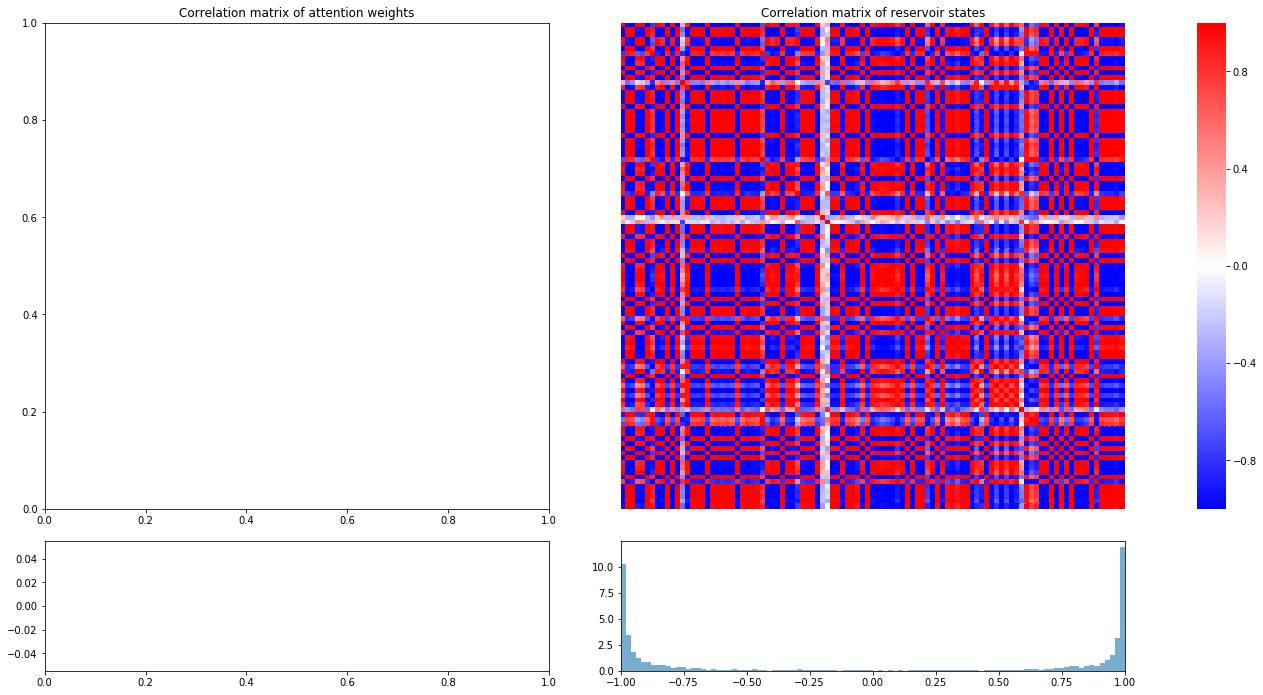

In [47]:

plt.figure(figsize = (20,9))
ax11 = plt.axes([0.1, 0.25, 0.35,0.75])
ax12 = plt.axes([0.5, 0.25, 0.35,0.75])
ax13 = plt.axes([0.9, 0.25, 0.02,0.75])
ax21 = plt.axes([0.1, 0.00, 0.35,0.2])
ax22 = plt.axes([0.5, 0.00, 0.35,0.2])

corr1 = pd.DataFrame(H1.T).corr()
# sns.heatmap(abs(corr1), ax=ax11, cbar=None, xticklabels=False, yticklabels=False)
ax11.set_title('Correlation matrix of attention weights')

corr2 = np.array(pd.DataFrame(H2.T).corr())
sns.heatmap(corr2, ax=ax12, cbar_ax=ax13, xticklabels=False, yticklabels=False, cmap='bwr')
ax12.set_title('Correlation matrix of reservoir states')

flatten1 = np.array(np.abs(corr1)).flatten()
_ = ax21.hist(flatten1, bins=100, histtype="stepfilled",density=True,alpha=0.6)
ax21.set_xlim([0,1])
# sns.kdeplot(flatten1,shade=True, ax = ax[1,0])
flatten2 = np.array(corr2).flatten()
_ = ax22.hist(flatten2, bins=100, histtype="stepfilled",density=True,alpha=0.6)
ax22.set_xlim([-1,1])

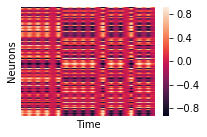

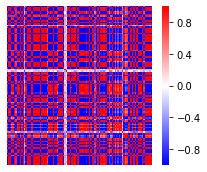

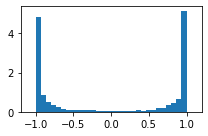

In [58]:
plt.figure(figsize=(3,2))
sns.heatmap(H2, xticklabels=False, yticklabels=False)
# plt.tight_layout()
# plt.title('State matrix')
plt.xlabel('Time')
plt.ylabel('Neurons')
plt.savefig(path+'/res_states.pdf')

plt.figure(figsize=(3,2.5))
sns.heatmap(corr2, xticklabels=False, yticklabels=False, cmap='bwr')
# plt.title('Correlation matrix')

plt.tight_layout()
plt.savefig(path+'/res_state_correlation.pdf')

plt.figure(figsize=(3,2))
flatten2 = np.array(corr2).flatten()
plt.hist(flatten2, bins=30, histtype="stepfilled",density=False,alpha=1)
plt.xlim([-1.2,1.2])
plt.tight_layout()
plt.savefig(path+'/res_state_corr_dist.pdf')

In [ ]:
plt.figure(figsize=(20,10))
temp = np.average(np.abs(corr2), axis=0)
mink = np.argsort(temp)[:10]
_ = plt.plot(H2[mink].T)

plt.figure(figsize=(20,10))
maxk = np.argsort(temp)[-10:]
_ = plt.plot(H2[maxk].T)

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(4,1,1)
plt.plot(np.sum(np.abs(model.W_o), axis=0))
plt.subplot(4,1,2)
plt.plot(H2[-1].T, label='input')
plt.legend()
plt.subplot(4,1,3)
maxk = np.argsort(np.sum(np.abs(model.W_o), axis=0))[-10:]
for i in range(len(maxk)):
    plt.plot(H[maxk[len(maxk)-1-i]].T, label=str(i)+' '+str(corr2[-1][maxk[len(maxk)-1-i]]))
plt.legend()
plt.subplot(4,1,4)
mink = np.argsort(np.sum(np.abs(model.W_o), axis=0)[:-1])[:10]
for i in range(len(mink)):
    plt.plot(H[mink[i]].T, label=str(i)+' '+str(corr2[-1][mink[i]]))
plt.legend()

In [ ]:
model.W_o.shape, H.shape

In [ ]:
%matplotlib qt5
plt.ion()

corr2 = np.array(corr2)

mink = [len(corr2)-1]
while len(mink) < 3:
    temp = np.max(np.abs(corr2[mink]), axis=0)
    mink.append(np.argsort(temp)[0])
print(mink)

plt.figure()
plt.plot(H2[mink].T)


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
ax.plot(*H2[mink])


In [ ]:
u, s, v = np.linalg.svd(H2, full_matrices=False)
# _ = plt.plot(range(len(s)), s)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
ax.plot(*v[:3])

plt.figure()
plt.plot(v[:3].T)

In [ ]:
_ = plt.plot((np.diag(1/s)@ u.T  @  H2).T)

In [ ]:
colors = ['#3f6899', '#9c403d', '#7d9847', '#675083', '#3b8ba1', '#c97937', '#898989']
%matplotlib inline

fig = plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(H1[58].T, color=colors[0], linestyle='--')
plt.plot(H1[10].T, color=colors[1])
plt.xticks([])
plt.xlim([0,1000])
plt.ylabel('Attention weights')
plt.subplot(3,1,2)
plt.plot(H2[0].T, color=colors[2], linestyle='--')
plt.plot(H2[99].T, color=colors[4], linestyle='-.')
plt.plot(H2[10].T, color=colors[3])
plt.xticks([])
plt.xlim([0,1000])
plt.ylabel('Neurons\' outputs')
plt.subplot(3,1,3)
plt.plot(x_test[-1,:1000].T, 'k')
plt.xlabel('Time')
plt.ylabel('Input Series')
plt.xlim([0,1000])
fig.align_labels()
# plt.savefig(path+'/weight_samples.pdf')
plt.show()

In [ ]:
colors = ['#3f6899', '#9c403d', '#7d9847', '#675083', '#3b8ba1', '#c97937', '#898989']
%matplotlib inline

fig = plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
plt.plot(1-np.max(H1,axis=0), color=colors[1])
plt.xticks([])
plt.xlim([0,1000])
plt.ylabel('Attention weights')
plt.subplot(2,1,2)
plt.plot(x_test[-1,:1000].T, 'k')
plt.xlabel('Time')
plt.ylabel('Input Series')
plt.xlim([0,1000])
fig.align_labels()
# plt.savefig(path+'/weight_samples.pdf')
plt.show()